In [1]:
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Load the CSV file containing movie reviews
reviews = pd.read_csv("imdb_labelled.csv")

# Perform sentiment analysis on each review
sid = SentimentIntensityAnalyzer()
reviews['sentiment'] = reviews['text'].apply(lambda x: sid.polarity_scores(x)['compound'])

# Classify the reviews as positive, negative or neutral
reviews['sentiment'] = reviews['sentiment'].apply(lambda x: 'positive' if x > 0.05 else ('negative' if x < -0.05 else 'neutral'))
reviews = reviews.drop('label', axis=1)

reviews.head(10)

,text,sentiment
0,"A very, very, very slow-moving, aimless movie ...",negative
1,Not sure who was more lost - the flat characte...,negative
2,Attempting artiness with black & white and cle...,negative
3,Very little music or anything to speak of.,neutral
4,The best scene in the movie was when Gerardo i...,positive
5,"The rest of the movie lacks art, charm, meanin...",negative
6,Wasted two hours.,negative
7,Saw the movie today and thought it was a good ...,positive
8,A bit predictable.,neutral
9,Loved the casting of Jimmy Buffet as the scien...,positive


In [2]:
positive_reviews = reviews[reviews["sentiment"] == "positive"]
positive_reviews.head(10)

,text,sentiment
4,The best scene in the movie was when Gerardo i...,positive
7,Saw the movie today and thought it was a good ...,positive
9,Loved the casting of Jimmy Buffet as the scien...,positive
10,And those baby owls were adorable.,positive
11,The movie showed a lot of Florida at it's best...,positive
12,The Songs Were The Best And The Muppets Were S...,positive
13,It Was So Cool.,positive
15,It had some average acting from the main perso...,positive
16,"This review is long overdue, since I consider ...",positive
18,It's practically perfect in all of them ¬ñ a t...,positive


In [3]:
negative_reviews = reviews[reviews["sentiment"] == "negative"]
negative_reviews.head(10)

,text,sentiment
0,"A very, very, very slow-moving, aimless movie ...",negative
1,Not sure who was more lost - the flat characte...,negative
2,Attempting artiness with black & white and cle...,negative
5,"The rest of the movie lacks art, charm, meanin...",negative
6,Wasted two hours.,negative
30,The problem was the script.,negative
31,It was horrendous.,negative
33,The only suspense I was feeling was the frustr...,negative
39,I don't think you will be disappointed.,negative
40,"Frankly, after Cotton club and Unfaithful, it ...",negative


In [4]:
neutral_reviews = reviews[reviews["sentiment"] == "neutral"]
neutral_reviews.head(10)

,text,sentiment
3,Very little music or anything to speak of.,neutral
8,A bit predictable.,neutral
14,"This is a very ""right on case"" movie that deli...",neutral
17,I'll put this gem up against any movie in term...,neutral
20,This if the first movie I've given a 10 to in ...,neutral
23,"Plus, it was well-paced and suited its relativ...",neutral
24,Give this one a look.,neutral
25,I gave it a 10,neutral
32,There was NOTHING believable about it at all.,neutral
36,The cast of veteran actors are more than just ...,neutral


In [5]:
totalNumberOfReviews = len(reviews)
numberOfPositiveReviews = len(positive_reviews)
numberOfNegativeReviews = len(negative_reviews)
reviews = len(negative_reviews)
numberOfNeutralReviews = len(neutral_reviews)
print("Total: ",totalNumberOfReviews )
print("Positive: ", numberOfPositiveReviews )
print("Negative: ", numberOfNegativeReviews )
print("Neutral: ", numberOfNeutralReviews)

Total:  748
Positive:  370
Negative:  256
Neutral:  122


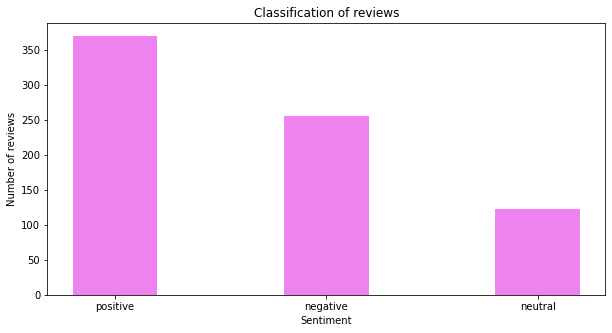

In [6]:
import numpy as np
import matplotlib.pyplot as plt


# creating the dataset

data = {'positive':370, 'negative':256, 'neutral':122}
sentiment = list(data.keys())
values = list(data.values())

fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(sentiment, values, color ='violet',
		width = 0.4)

plt.xlabel("Sentiment")
plt.ylabel("Number of reviews")
plt.title("Classification of reviews")
plt.show()


In [7]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import silhouette_score
from gensim.summarization.summarizer import summarize
import transformers
from transformers import T5Tokenizer, T5ForConditionalGeneration

# Vectorize the text using CountVectorizer
vectorizer = CountVectorizer(stop_words="english")
X = vectorizer.fit_transform(positive_reviews["text"])

# Determine the optimal number of clusters using silhouette score
sil_scores = []
for n_clusters in range(2, 11):
    lda = LatentDirichletAllocation(n_components=n_clusters, random_state=42)
    lda.fit(X)
    dominant_topic = lda.transform(X).argmax(axis=1)
    sil_scores.append(silhouette_score(X, dominant_topic))
optimal_n_clusters = sil_scores.index(max(sil_scores)) + 2
print(sil_scores)
print()
# Cluster the text using LDA
lda = LatentDirichletAllocation(n_components=optimal_n_clusters, random_state=42)
lda.fit(X)
dominant_topic = lda.transform(X).argmax(axis=1)

# Store the cluster number and number of statements in each cluster
cluster_stats = {}
for i, text in enumerate(positive_reviews["text"]):
    cluster = dominant_topic[i]
    if cluster in cluster_stats:
        cluster_stats[cluster] += 1
    else:
        cluster_stats[cluster] = 1
        
# Initialize the T5 model and tokenizer
tokenizer = T5Tokenizer.from_pretrained("t5-small")
model = T5ForConditionalGeneration.from_pretrained("t5-small")

"""
# Summarize each cluster and print the number of statements
for i in range(optimal_n_clusters):
    cluster_text = positive_reviews[dominant_topic == i]["text"]
    summary = summarize(" ".join(cluster_text))
    count = cluster_stats[i]["count"]
    print(f"Cluster {i+1} summary ({count} statements): {summary}")
    print()
    print()
"""

# Summarize each cluster using T5 and print the number of statements
for i in range(optimal_n_clusters):
    cluster_text = positive_reviews[dominant_topic == i]["text"]
    input_text = "summarize: " + " ".join(cluster_text)
    input_ids = tokenizer.encode(input_text, return_tensors="pt", max_length=512, truncation=True)
    summary_ids = model.generate(input_ids, max_length=50, num_beams=4, early_stopping=True)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    count = cluster_stats[i]
    print(f"Cluster {i+1} summary ({count} statements): {summary}")
    print()
    print()
    


[0.0023556466863411205, -0.03367835917681703, -0.04043980187708576, -0.05719954694040377, -0.0755193550219487, -0.06936230295702399, -0.08529609157454998, -0.0804907533376024, -0.10048376859388658]

Cluster 1 summary (211 statements): MANNA FROM HEAVEN is a terrific film that is both predictable and unpredictable at the same time. the only thing really worth watching was the scenery and the house, because it is beautiful. the only possible way this


Cluster 2 summary (159 statements): the best scene in the movie was when Gerardo is trying to find a song that keeps running through his head. this review is long overdue, since I consider A Tale of Two Sisters to be the single greatest film




Number of optimal clusters:  2
{1: 159, 0: 211}


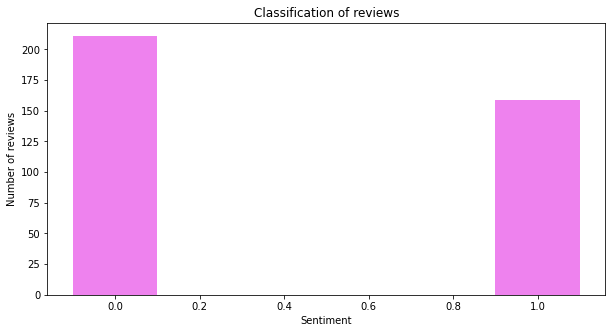

In [8]:
import numpy as np
import matplotlib.pyplot as plt


# creating the dataset

data = cluster_stats
sentiment = list(data.keys())
values = list(data.values())

fig = plt.figure(figsize = (10, 5))

print("Number of optimal clusters: ", optimal_n_clusters)
print(cluster_stats)

# creating the bar plot
plt.bar(sentiment, values, color ='violet',
		width = 0.2)

plt.xlabel("Sentiment")
plt.ylabel("Number of reviews")
plt.title("Classification of reviews")
plt.show()

In [9]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from gensim.summarization.summarizer import summarize
import transformers
from transformers import T5Tokenizer, T5ForConditionalGeneration

# Vectorize the text using tf-idf
vectorizer = TfidfVectorizer(stop_words="english")
X = vectorizer.fit_transform(positive_reviews["text"])

# Determine the optimal number of clusters using silhouette score
sil_scores = []
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X)
    labels = kmeans.labels_
    sil_scores.append(silhouette_score(X, labels))
optimal_n_clusters = sil_scores.index(max(sil_scores)) + 2
print(sil_scores)
print()
# Cluster the text using KMeans
kmeans = KMeans(n_clusters=optimal_n_clusters, random_state=42)
kmeans.fit(X)
labels = kmeans.labels_

# Store the cluster number and number of statements in each cluster
cluster_stats = {}
for i, text in enumerate(positive_reviews["text"]):
    cluster = labels[i]
    if cluster in cluster_stats:
        cluster_stats[cluster] += 1
    else:
        cluster_stats[cluster] = 1
        
# Initialize the T5 model and tokenizer
tokenizer = T5Tokenizer.from_pretrained("t5-small")
model = T5ForConditionalGeneration.from_pretrained("t5-small")

# Summarize each cluster using T5 and print the number of statements
for i in range(optimal_n_clusters):
    cluster_text = positive_reviews[labels == i]["text"]
    input_text = "summarize: " + " ".join(cluster_text)
    input_ids = tokenizer.encode(input_text, return_tensors="pt", max_length=512, truncation=True)
    summary_ids = model.generate(input_ids, max_length=50, num_beams=4, early_stopping=True)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    count = cluster_stats[i]
    print(f"Cluster {i+1} summary ({count} statements): {summary}")
    print()
    print()


[0.00521705564928784, 0.007727651018018427, 0.008222615323636323, 0.006970982382790906, 0.008434134163681096, 0.009373864614353768, 0.01311830637843283, 0.011746371291105544, 0.012517334687099719]

Cluster 1 summary (72 statements): the acting helps the writing along very well, and it is a real joy to watch. it rocked my world and is certainly a must see for anyone with no social or physical outlets.


Cluster 2 summary (52 statements): the best scene in the movie was when Gerardo is trying to find a song that keeps running through his head. the only possible way this movie could be redeemed would be as MST3K fodder.


Cluster 3 summary (153 statements): MANNA FROM HEAVEN is a terrific film that is both predictable and unpredictable at the same time. the scenes are often funny and occasionally touching as the characters evaluate their lives and where they are going. this is one


Cluster 4 summary (14 statements): steve martin delivers a really funny performance of a middle-aged, upper

Number of optimal clusters:  8
{1: 52, 5: 34, 0: 72, 2: 153, 4: 7, 6: 32, 3: 14, 7: 6}


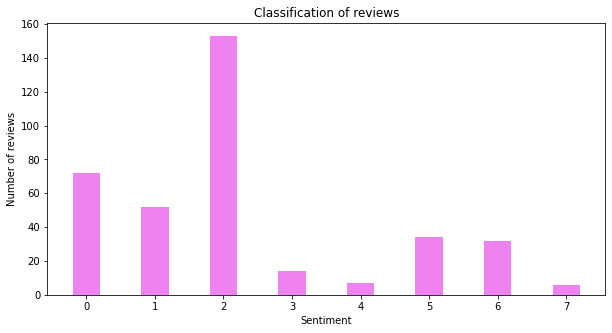

In [10]:
import numpy as np
import matplotlib.pyplot as plt


# creating the dataset

data = cluster_stats
sentiment = list(data.keys())
values = list(data.values())

fig = plt.figure(figsize = (10, 5))

print("Number of optimal clusters: ", optimal_n_clusters)
print(cluster_stats)

# creating the bar plot
plt.bar(sentiment, values, color ='violet',
		width = 0.4)

plt.xlabel("Sentiment")
plt.ylabel("Number of reviews")
plt.title("Classification of reviews")
plt.show()

In [11]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import silhouette_score
from gensim.summarization.summarizer import summarize
import transformers
from transformers import T5Tokenizer, T5ForConditionalGeneration

# Vectorize the text using CountVectorizer
vectorizer = CountVectorizer(stop_words="english")
X = vectorizer.fit_transform(negative_reviews["text"])

# Determine the optimal number of clusters using silhouette score
sil_scores = []
for n_clusters in range(2, 11):
    lda = LatentDirichletAllocation(n_components=n_clusters, random_state=42)
    lda.fit(X)
    dominant_topic = lda.transform(X).argmax(axis=1)
    sil_scores.append(silhouette_score(X, dominant_topic))
optimal_n_clusters = sil_scores.index(max(sil_scores)) + 2
print(sil_scores)
print()
# Cluster the text using LDA
lda = LatentDirichletAllocation(n_components=optimal_n_clusters, random_state=42)
lda.fit(X)
dominant_topic = lda.transform(X).argmax(axis=1)

# Store the cluster number and number of statements in each cluster
cluster_stats = {}
for i, text in enumerate(negative_reviews["text"]):
    cluster = dominant_topic[i]
    if cluster in cluster_stats:
        cluster_stats[cluster] += 1
    else:
        cluster_stats[cluster] = 1
        
# Initialize the T5 model and tokenizer
tokenizer = T5Tokenizer.from_pretrained("t5-small")
model = T5ForConditionalGeneration.from_pretrained("t5-small")

# Summarize each cluster using T5 and print the number of statements
for i in range(optimal_n_clusters):
    cluster_text = negative_reviews[dominant_topic == i]["text"]
    input_text = "summarize: " + " ".join(cluster_text)
    input_ids = tokenizer.encode(input_text, return_tensors="pt", max_length=512, truncation=True)
    summary_ids = model.generate(input_ids, max_length=50, num_beams=4, early_stopping=True)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    count = cluster_stats[i]
    print(f"Cluster {i+1} summary ({count} statements): {summary}")
    print()
    print()
    


[0.0025992795368206885, -0.03661775352956103, -0.039555196363462816, -0.043051134215315354, -0.054338714441533896, -0.04683533560244321, -0.046415005423414216, -0.0677926595973951, -0.06527200791090948]

Cluster 1 summary (126 statements): a very, very, very slow-moving, aimless movie about a distressed, drifting young man. the movie disappointed - became even more ridiculous - as the acting was poor and the dialogues were extremely shallow


Cluster 2 summary (130 statements): this movie has no redeeming features. everything is appalling. this movie has no redeeming features. Everything is appalling.




Number of optimal clusters:  2
{0: 126, 1: 130}


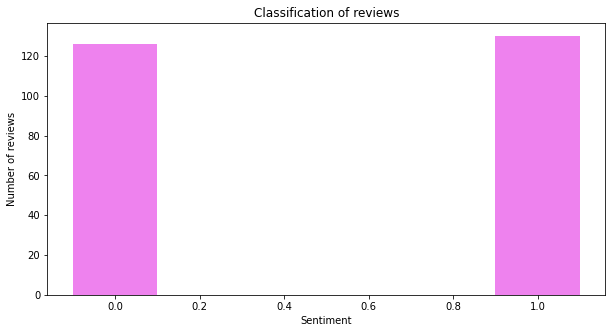

In [12]:
import numpy as np
import matplotlib.pyplot as plt


# creating the dataset

data = cluster_stats
sentiment = list(data.keys())
values = list(data.values())

fig = plt.figure(figsize = (10, 5))

print("Number of optimal clusters: ", optimal_n_clusters)
print(cluster_stats)

# creating the bar plot
plt.bar(sentiment, values, color ='violet',
		width = 0.2)

plt.xlabel("Sentiment")
plt.ylabel("Number of reviews")
plt.title("Classification of reviews")
plt.show()

In [13]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from gensim.summarization.summarizer import summarize
import transformers
from transformers import T5Tokenizer, T5ForConditionalGeneration

# Vectorize the text using tf-idf
vectorizer = TfidfVectorizer(stop_words="english")
X = vectorizer.fit_transform(negative_reviews["text"])

# Determine the optimal number of clusters using silhouette score
sil_scores = []
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X)
    labels = kmeans.labels_
    sil_scores.append(silhouette_score(X, labels))
optimal_n_clusters = sil_scores.index(max(sil_scores)) + 2
print(sil_scores)
print()
# Cluster the text using KMeans
kmeans = KMeans(n_clusters=optimal_n_clusters, random_state=42)
kmeans.fit(X)
labels = kmeans.labels_

# Store the cluster number and number of statements in each cluster
cluster_stats = {}
for i, text in enumerate(negative_reviews["text"]):
    cluster = labels[i]
    if cluster in cluster_stats:
        cluster_stats[cluster] += 1
    else:
        cluster_stats[cluster] = 1

cluster_text = {}
# Initialize the T5 model and tokenizer
tokenizer = T5Tokenizer.from_pretrained("t5-small")
model = T5ForConditionalGeneration.from_pretrained("t5-small")

# Summarize each cluster using T5 and print the number of statements
for i in range(optimal_n_clusters):
    cluster_text = negative_reviews[labels == i]["text"]
    input_text = "summarize: " + " ".join(cluster_text)
    print(input_text)
    print()
    input_ids = tokenizer.encode(input_text, return_tensors="pt", max_length=512, truncation=True)
    summary_ids = model.generate(input_ids, max_length=50, num_beams=4, early_stopping=True)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    count = cluster_stats[i]
    print(f"Cluster {i+1} summary ({count} statements): {summary}")
    print()
    print()

[0.005715520597363183, 0.009702043336889518, 0.013423743273566425, 0.015519022145079404, 0.013768805818440488, 0.018503783016941153, 0.021178609685103596, 0.017935481621298845, 0.022719339052477104]

summarize: Frankly, after Cotton club and Unfaithful, it was kind of embarrassing to watch Lane and Gere in this film, because it is BAD.   The acting was bad, the dialogs were extremely shallow and insincere.   This is a bad film, with bad writing, and good actors....an ugly cartoon crafted by Paul Haggis for people who can't handle anything but the bold strokes in storytelling....a picture painted with crayons.   Crash is a depressing little nothing, that provokes emotion, but teaches you nothing if you already know racism and prejudice are bad things.   Yes, it's that bad.   I am a fan of his ... This movie sucked really bad.   & That movie was bad.   The sets are so bad, they wouldn't look out of place on a Thunderbirds episode.   The use of slow-motion needlessly repeats itself throug

Cluster 4 summary (29 statements): this film is an hour and half waste of time, following a bunch of very pretty high schoolers whine and cry about life. it is a monumental waste of time, following a bunch of very pretty high schoolers wh


summarize: IMDB ratings only go as low 1 for awful, it's time to get some negative numbers in there for cases such as these.   Awful.   Even the squibs look awful.   The awful dialogue and hopeless overacting by everyone who gets shot top off a real waste of space and time.   The lighting is awful.   The visual effects were AWFUL.   The "explosion" of the Gas tanks at the end was just as awful.   The story line is just awful!   This movie is so mind-bendingly awful, it couldn't have even been created.   How awful she is!   The attempts at humor were pitiful and story is so awful it dosen't bear thinking about which basically involves a Vulcan stealing the Enterprise to find god (seriously) I just didn't care about any of this film and oh not to ment

Cluster 6 summary (101 statements): john avlon: i thought the actor playing the villain was a low rent Michael Ironside. avlon: inexperience of direction meant that scene after scene passed with little in the way of dramatic


summarize: A very, very, very slow-moving, aimless movie about a distressed, drifting young man.   The rest of the movie lacks art, charm, meaning... If it's about emptiness, it works I guess because it's empty.   I love Lane, but I've never seen her in a movie this lousy.   The movie was so boring, that I sometimes found myself occupied peaking in the paper instead of watching (never happened during a Columbo movie before!   Then scene where they debated whether or not to sack the trumpeter (who falsely was accused for the murder) is pure horror, really stupid.   This movie is a pure disaster, the story is stupid and the editing is the worst I have seen, it confuses you incredibly.   I don't think I've ever gone to a movie and disliked it as much.   This movie n

Cluster 7 summary (38 statements): this movie joins Revenge of the Boogeyman and Zombiez as part of the hellish trinity of horror films. all this movie does is make you sick watching all these slackers make


summarize: The kids are annoying.   It didn't make me scared, horrified, or make me sympathetic towards the characters; it was simply annoying.   The jerky camera movements were also annoying.   The most annoying thing about 'Cover Girl' is the way in which Rita Hayworth is put up on a pedestal.   It is indescribably the most annoying and idiotic show I have ever seen.   Every time he opened his mouth you expect to hear, "you see kids..." Pulling the plug was a mercy killing for this horrible show.  

Cluster 8 summary (6 statements): the kids are annoying, it didn't make me scared, horrified, or make me sympathetic to the characters. the most annoying thing about 'Cover Girl' is the way in which Rita Hayworth is put up on


summarize: Attempting artiness with black & white and cl

In [14]:
cluster_stats

{6: 38, 5: 101, 8: 15, 0: 31, 2: 10, 3: 29, 4: 12, 1: 8, 7: 6, 9: 6}

Number of optimal clusters:  10
{6: 38, 5: 101, 8: 15, 0: 31, 2: 10, 3: 29, 4: 12, 1: 8, 7: 6, 9: 6}


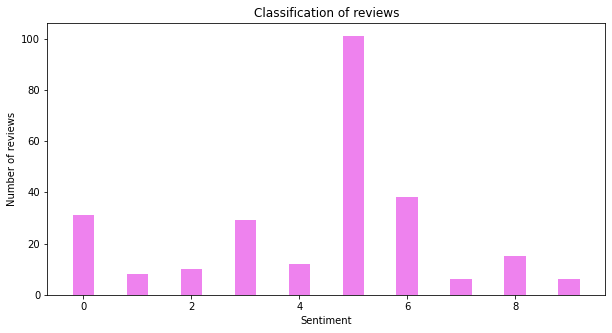

In [15]:
import numpy as np
import matplotlib.pyplot as plt


# creating the dataset

data = cluster_stats
sentiment = list(data.keys())
values = list(data.values())

fig = plt.figure(figsize = (10, 5))

print("Number of optimal clusters: ", optimal_n_clusters)
print(cluster_stats)

# creating the bar plot
plt.bar(sentiment, values, color ='violet',
		width = 0.4)

plt.xlabel("Sentiment")
plt.ylabel("Number of reviews")
plt.title("Classification of reviews")
plt.show()